# Project 4: Regression Analysis and Define Your Own Task!

##### Group Member
Yifu Yuan, 804973353  
Zhiquan You, 205667859  
Wenxuan Wu, 705846929

### Question 1. Standardize feature columns and prepare them for training.

In [2]:
pip install -q pydot

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-optimize


     |████████████████████████████████| 100 kB 3.7 MB/s 


In [3]:
pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [3]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import lightgbm as lgb
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
import pydot
from sklearn.tree import export_graphviz
from IPython.display import Image

In [4]:
def cross_validation(model, X, y, n_splits=10):
    kf = KFold(n_splits=n_splits)
    train_rmse, test_rmse = 0, 0
    for train, test in kf.split(X):
        train_data, train_target = X.loc[train], y.loc[train]
        test_data, test_target = X.loc[test], y.loc[test]
        model.fit(train_data, train_target)
        train_pred, test_pred = model.predict(train_data), model.predict(test_data)
        train_rmse += metrics.mean_squared_error(train_target, train_pred) ** 0.5
        test_rmse += metrics.mean_squared_error(test_target, test_pred) ** 0.5
    return train_rmse/n_splits, test_rmse/n_splits

In [6]:
diamond_df = pd.read_csv('diamonds.csv')
gt_2011 = pd.read_csv('gt_2011.csv')
gt_2012 = pd.read_csv('gt_2012.csv')
gt_2013 = pd.read_csv('gt_2013.csv')
gt_2014 = pd.read_csv('gt_2014.csv')
gt_2015 = pd.read_csv('gt_2015.csv')

In [7]:
all_files = ['gt_2011.csv','gt_2012.csv', 'gt_2013.csv','gt_2014.csv', 'gt_2015.csv']
arr = []
for filename in all_files:
    year = filename.split("_")[1].split('.')[0]
    df = pd.read_csv(filename, index_col=None, header=0)
    row, col = df.shape
    year_col = [year] * row
    df['Year'] = year_col
    arr.append(df)

gt_df = pd.concat(arr, axis=0, ignore_index=True)
gt_df.drop(columns=["NOX"], inplace=True)
gt_df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,Year
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,2011
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,2011
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,2011
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,2011
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,2011
...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,2015
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,2015
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,2015
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,2015


In [8]:
diamond_df = diamond_df.iloc[:, 1:]
diamond_df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,330,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,327,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,328,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,337,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,338,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2758,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2759,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2760,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [9]:
cut_to_num = {'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}
color_to_num = {'J':0, 'I':1,'H':2, 'G':3, 'F':4, 'E':4, 'D':5}
clarity_to_num = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2':3, 'VS1': 4, 'VVS2': 5, 'VVS1':6, 'IF':7}

diamond_df['cut'].replace(cut_to_num, inplace=True)
diamond_df['color'].replace(color_to_num, inplace=True)
diamond_df['clarity'].replace(clarity_to_num, inplace=True)

diamond_df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,4,1,61.5,55.0,330,3.95,3.98,2.43
1,0.21,3,4,2,59.8,61.0,327,3.89,3.84,2.31
2,0.23,1,4,4,56.9,65.0,328,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,337,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,338,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,4,5,2,60.8,57.0,2758,5.75,5.76,3.50
53936,0.72,1,5,2,63.1,55.0,2759,5.69,5.75,3.61
53937,0.70,2,5,2,62.8,60.0,2760,5.66,5.68,3.56
53938,0.86,3,2,1,61.0,58.0,2757,6.15,6.12,3.74


In [10]:
diamond_numerical = ['carat', 'depth', 'table', 'x', 'y', 'z']
diamond_categorical = ['cut', 'color', 'clarity']
diamond_std = StandardScaler().fit_transform(diamond_df.values)
diamond_std_df = pd.DataFrame(diamond_std, index=diamond_df.index, columns=diamond_df.columns)
diamond_std_df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,-1.198168,0.981473,0.658175,-1.245215,-0.174092,-1.099672,-0.903594,-1.587837,-1.536196,-1.571129
1,-1.240361,0.085889,0.658175,-0.638095,-1.360738,1.585529,-0.904346,-1.641325,-1.658774,-1.741175
2,-1.198168,-1.705279,0.658175,0.576145,-3.385019,3.375663,-0.904095,-1.498691,-1.457395,-1.741175
3,-1.071587,0.085889,-1.532267,-0.030975,0.454133,0.242928,-0.901839,-1.364971,-1.317305,-1.287720
4,-1.029394,-1.705279,-2.262415,-1.245215,1.082358,0.242928,-0.901588,-1.240167,-1.212238,-1.117674
...,...,...,...,...,...,...,...,...,...,...
53935,-0.164427,0.981473,1.388322,-0.638095,-0.662711,-0.204605,-0.294982,0.016798,0.022304,-0.054888
53936,-0.164427,-1.705279,1.388322,-0.638095,0.942753,-1.099672,-0.294731,-0.036690,0.013548,0.100988
53937,-0.206621,-0.809695,1.388322,-0.638095,0.733344,1.137995,-0.294480,-0.063434,-0.047741,0.030135
53938,0.130927,0.085889,-0.802120,-1.245215,-0.523105,0.242928,-0.295232,0.373383,0.337506,0.285204


In [11]:
gt_numerical = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']
gt_categorical = ['Year']
gt_std = StandardScaler().fit_transform(gt_df.values)
gt_std_df = pd.DataFrame(gt_std, index=gt_df.index, columns=gt_df.columns)
gt_std_df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,Year
0,-1.762362,0.871052,0.401627,-0.451875,-0.377702,0.272119,0.536589,0.074502,-0.149273,-0.904182,-1.399443
1,-1.801920,0.809164,0.440351,-0.458207,-0.384376,0.266417,0.568742,0.074502,-0.154783,-0.850611,-1.399443
2,-1.854113,0.824636,0.483432,-0.442831,-0.375081,0.289227,0.589203,0.102033,-0.017015,-0.849020,-1.399443
3,-1.875718,0.809164,0.523263,-0.445415,-0.393909,0.289227,0.586280,0.097551,-0.064774,-0.946415,-1.399443
4,-1.874644,0.731804,0.505837,-0.448904,-0.392479,0.255012,0.561434,0.074502,-0.138251,-0.930328,-1.399443
...,...,...,...,...,...,...,...,...,...,...,...
36728,-1.891401,2.387315,1.060287,-0.981255,-1.543602,-2.533516,-0.667691,-1.563948,-1.515021,3.809943,1.419550
36729,-1.818812,2.402787,1.118097,-0.947401,-1.560524,-2.499301,-0.566847,-1.582516,-1.576558,3.876679,1.419550
36730,-1.642292,2.387315,1.199903,-0.791702,-1.598418,-2.476491,-0.391466,-1.645262,-1.468179,3.996008,1.419550
36731,-1.588354,2.418260,1.129438,0.074403,-0.476847,-0.258214,0.577511,-0.134226,-0.265917,0.415856,1.419550


### Question 2. Plot a heatmap of the Pearson correlation matrix of the dataset columns. Report which features have the highest absolute correlation with the target variable. In the context of each dataset, describe what this high correlation suggests.

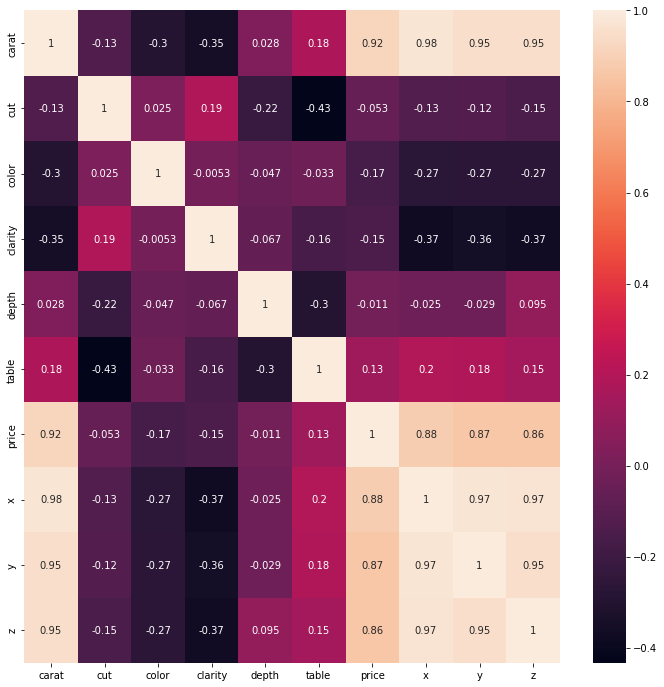

In [12]:
plt.figure(figsize = (12, 12))
diamond_heatmap = sns.heatmap(diamond_std_df.corr(method = "pearson"), annot = True)
plt.show()

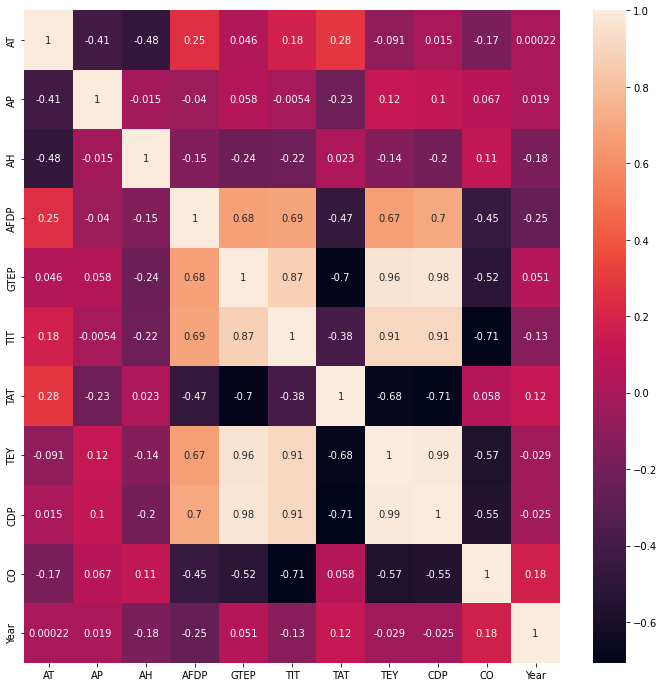

In [ ]:
plt.figure(figsize = (12, 12))
gt_heatmap = sns.heatmap(gt_std_df.corr(method = "pearson"), annot = True)
plt.show()

1. For diamond, the highest absolute correlation is feature carat. This makes sense because generally speaking greater the carat, the more expensive is the diamond.
2. For emission, the highest absolute correlation is TIT. As CO and TIT as of negative correlation, the greater TIT is, the smaller CO emission is.

### Question 3. Plot the histogram of numerical features. What preprocessing can be done if the distribution of a feature has high skewness?

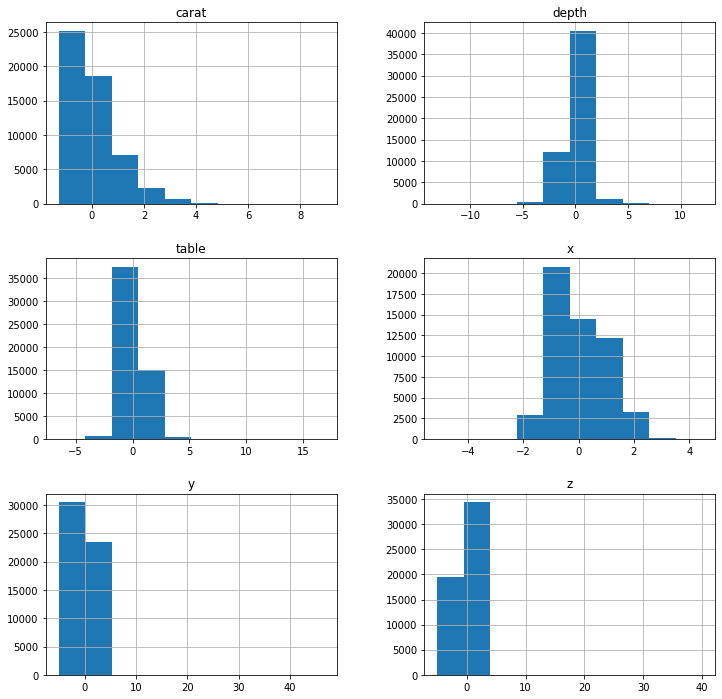

In [ ]:
#diamond_feature = diamond_std_df.columns.values.tolist()
_ = diamond_std_df.hist(column = diamond_numerical, figsize = (12, 12))

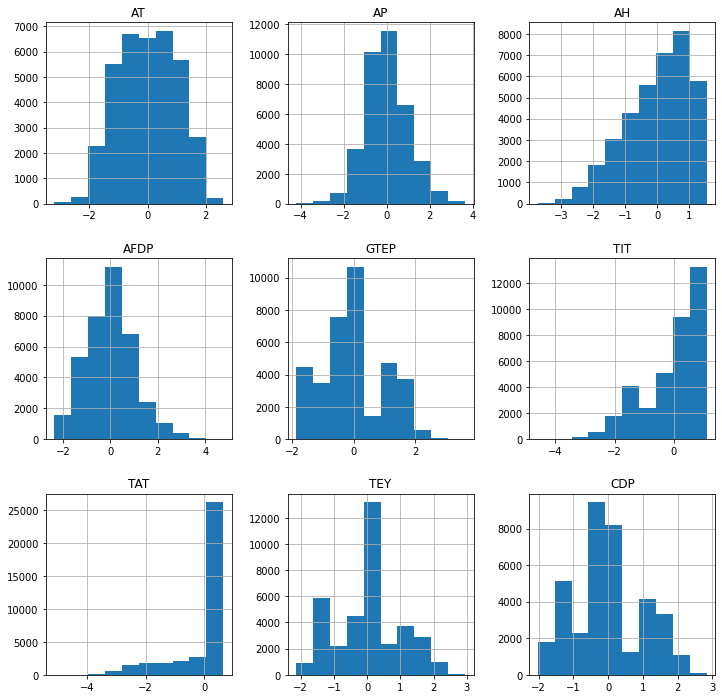

In [ ]:
#gt_feature = gt_std_df.columns.values.tolist()[:-2]
_ = gt_std_df.hist(column = gt_numerical, figsize = (12, 12))

If a feature F is highly skewed, we can try to down sample data points whose F falls in the skewed region. Namely, decrease the number of samples that has a skewed value of feature F.

### Question 4. Construct and inspect the box plot of categorical features vs target variable. What do you find?

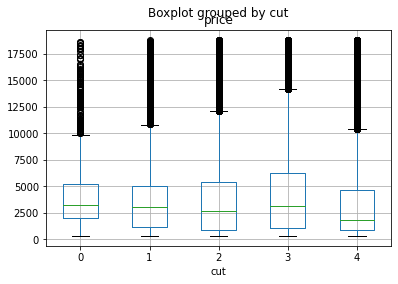

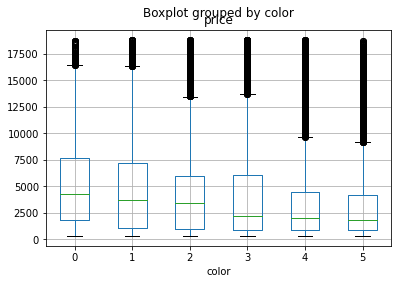

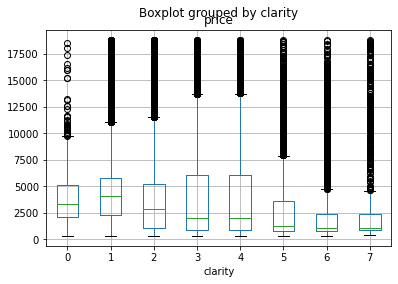

In [ ]:
#dimond_feature = dimond_std_df.columns.values.tolist()
#dimond_feature.pop(0)
#dimond_feature.remove('price')

for feature in diamond_categorical:
    diamond_df.boxplot(column='price', by=feature)
    plt.show()

#diamond_feature

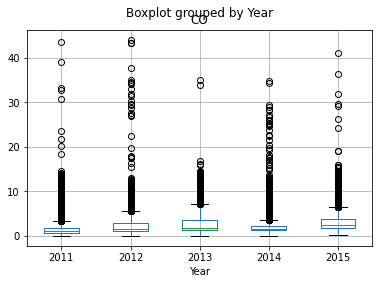

In [ ]:
#gt_feature = gt_std_df.columns.values.tolist()
#gt_feature.remove('NOX')

for feature in gt_categorical:
    gt_df.boxplot(column='CO', by=feature)
    plt.show()



### Question 5. For the Diamonds dataset, plot the counts by color, cut and clarity.

In [ ]:
def plot_bar(x, y, xlabel, ylabel, title):
  plt.bar(x, y)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.title(title)

  plt.show()

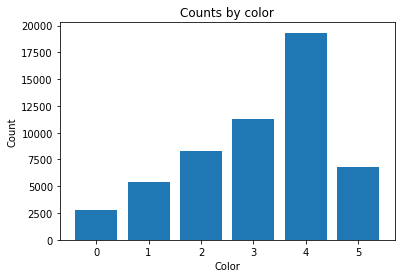

In [ ]:
color = diamond_df['color']
color_count = Counter(color)
plot_bar(color_count.keys(), color_count.values(), 'Color', 'Count', 'Counts by color')

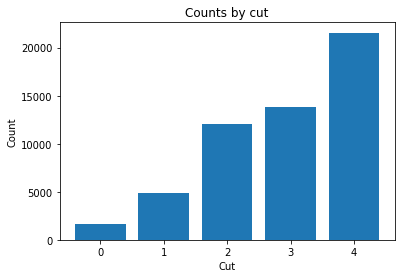

In [ ]:
cut = diamond_df['cut']
cut_count = Counter(cut)
plot_bar(cut_count.keys(), cut_count.values(), 'Cut', 'Count', 'Counts by cut')

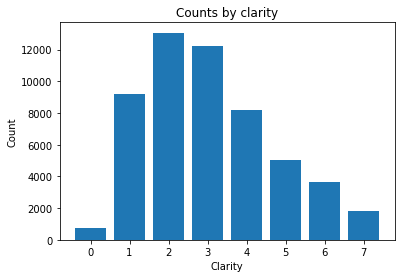

In [ ]:
clarity = diamond_df['clarity']
clarity_count = Counter(clarity)
plot_bar(clarity_count.keys(), clarity_count.values(), 'Clarity', 'Count', 'Counts by clarity')

### Question 6. For the Gas Emission dataset, plot the yearly trends for each feature and compare them. The data points don’t have timestamps but you may assume the indeces are times.

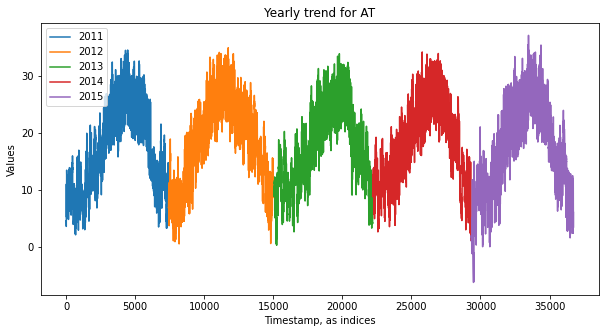

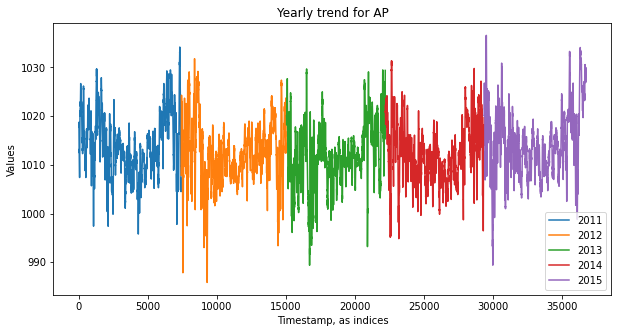

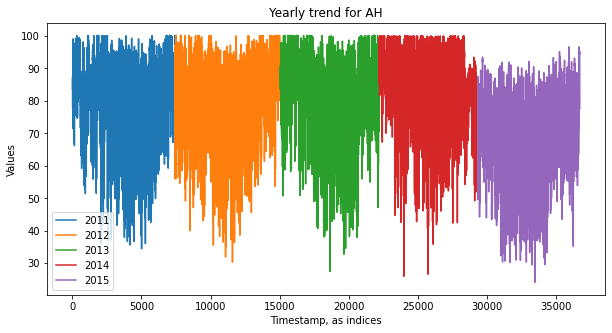

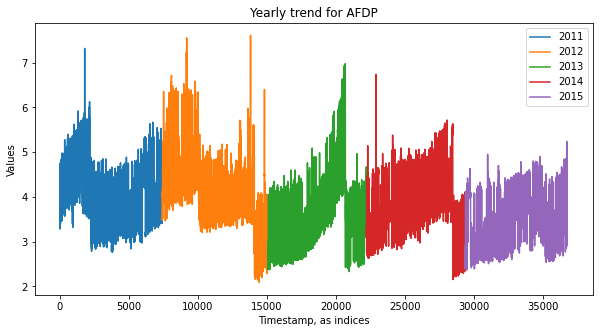

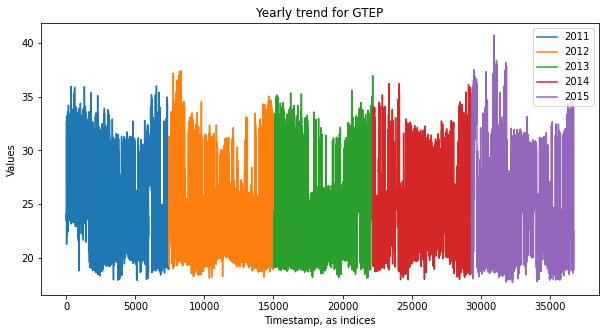

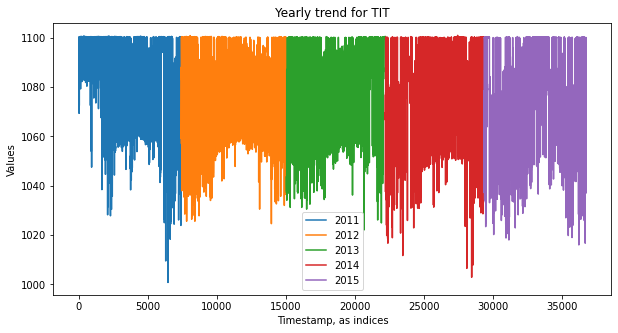

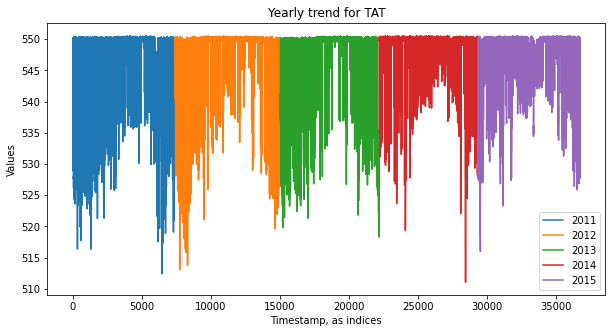

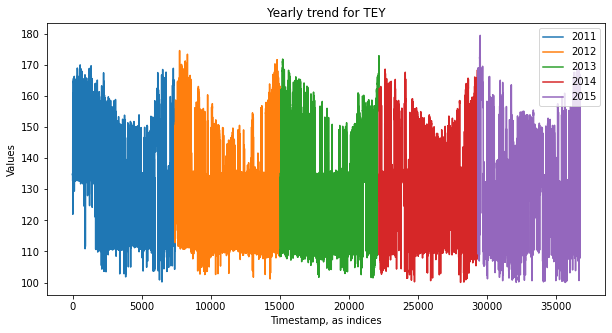

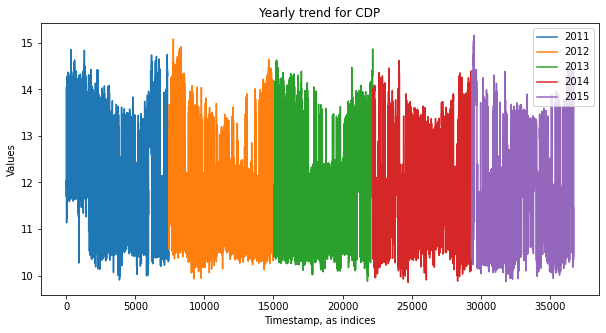

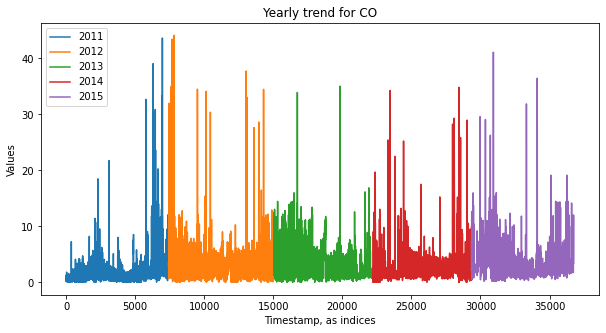

In [ ]:
gt_feature = gt_df.columns.values.tolist()
gt_feature.remove('Year')

for feature in gt_feature:
  fig, ax = plt.subplots(1,1, figsize=(10, 5))
  gt = gt_df.groupby(by=['Year'])[feature].plot(ax=ax,legend=True)
  ax.set_xlabel("Timestamp, as indices")
  ax.set_ylabel("Values")
  ax.set_title('Yearly trend for ' + feature)
  # for key, val in gt:
  #   plt.xlabel('TimeStamp (as indices)')
  #   plt.ylabel('Value')
  #   plt.title('Yearly trend for ' + feature)
  #   plt.plot(val.index, val, label=key)
  #   plt.legend()
  #   plt.show()

We do observe that each feature has very similar yearly trend over the five year periods, although there are some fluctuations and minor differences in the beginning or end of each year.

### Question 7: Select most important features

In [ ]:
diamond_mi = mutual_info_regression(diamond_std_df.loc[:, diamond_std_df.columns!='price'], diamond_std_df['price'])
print(diamond_mi)

[1.65169359 0.05748899 0.11627508 0.2179626  0.03099212 0.0362559
 1.41244916 1.42296169 1.36097982]


In [ ]:
gt_mi = mutual_info_regression(gt_std_df.loc[:, gt_std_df.columns!='CO'], gt_std_df['CO'])
print(gt_mi)

[0.10487619 0.04216339 0.02552766 0.27863531 0.44541326 0.53672019
 0.16210226 0.49550705 0.47417368 0.12439899]


1. From the printed mutial info above, for diamond we will select carat, cut, color, clarity, x, y and z, for gas emission we will select AT, AFDP, GTEP, TIT, TAT, TEY and CDP, Year as the most important features. 
2. Feature selection generally speaking avoids overfitting by eliminating redundant data and improves accuracy as a result of less misleading data. Therefore, RMSE will be decreased after correct feature selection.

### Question 8: Explain how each regularization scheme affects the learned hypotheses

The objective function of Ordinary least square is:
\begin{align}
  Σ_{i=1}^n(y_{i} - Σ_{j}x_{ij}β_{j})^2 
\end{align}
The objective function of Lasso Regression is :
\begin{align}
  Σ_{i=1}^n(y_{i} - Σ_{j}x_{ij}β_{j})^2 + λ Σ_{j=1}^p |β_{j}|
\end{align}

The objective function of Ridge Regression is: 
\begin{align}
  Σ_{i=1}^n(y_{i} - Σ_{j}x_{ij}β_{j})^2 + λ Σ_{j=1}^p β_{j}^2
\end{align}

where y is the target variable, x is the features, and β represents weights assigned to each feature, λ is the regulazation strength


L1 regularization will force some less important weights to 0 and thus achieve the goal of feature elimination. L2 regularization on the other hand does not easily give up any feature but instead drive weights closer to 0 on each dimension. If one wants to "cut out" some features in learnt coefficients, one might use L1 regularization as it zeroes out some features. If one wants to have simple/smaller model/coefficients, then he can use L2 regularization as this regularization tend to make coefficients shrink in the direction of their respective axis.


### Question 9: Report your choice of the best regularization scheme along with the optimal penalty sorted(sklearn.metrics.SCORERS.keys())parameter and briefly explain how it can be computed.

In [87]:
def test_reg_scheme(model, alpha_list, feature, target):
  best_rmse, best_alpha = float('inf'), 0
  train_rmse_list = []
  test_rmse_list = []
  for a in alpha_list:
    if model == 'Lasso':
      lasso = Lasso(alpha=a)
      train_rmse, test_rmse = cross_validation(lasso, feature, target)
      train_rmse_list.append(train_rmse)
      test_rmse_list.append(test_rmse)

    elif model == 'Ridge':
      ridge = Ridge(alpha=a)
      train_rmse, test_rmse = cross_validation(ridge, feature, target)
      train_rmse_list.append(train_rmse)
      test_rmse_list.append(test_rmse)

    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_alpha = a
  print("For", model, "Regression, the smallest rmse is {:.4f} obtained by alpha {}".format(best_rmse, best_alpha))
  return train_rmse_list, test_rmse_list

For dimond dataset

In [ ]:
linear_regression = LinearRegression(n_jobs=-1)
print("RMSE on dimond dataset with feature selection & with standardization")
print(cross_validation(linear_regression, diamond_std_df[['carat','cut', 'color',	'clarity','x', 'y', 'z']], diamond_std_df['price']))
print("RMSE on dimond dataset without feature selection & with standardization")
print(cross_validation(linear_regression, diamond_std_df.drop(columns=['price'], inplace=False), diamond_std_df['price']))
print("RMSE on dimond dataset with feature selection & without standardization")
print(cross_validation(linear_regression, diamond_df[['carat','cut', 'color',	'clarity','x', 'y', 'z']], diamond_df['price']))
print("RMSE on dimond dataset without feature selection & without standardization")
print(cross_validation(linear_regression, diamond_df.drop(columns=['price'], inplace=False), diamond_df['price']))

RMSE on dimond dataset with feature selection & with standardization
(0.30099179935896436, 0.30263214153993284)
RMSE on dimond dataset without feature selection & with standardization
(0.3001816974990362, 0.3005340792391373)
RMSE on dimond dataset with feature selection & without standardization
(1200.7782919201238, 1207.3222817777296)
RMSE on dimond dataset without feature selection & without standardization
(1197.5464672334797, 1198.9522608294637)


In [88]:
alpha_list = [10**i for i in range(-5, 6)]

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Lasso', alpha_list=alpha_list, feature=diamond_std_df[['carat','cut', 'color',	'clarity','x', 'y', 'z']], target=diamond_std_df['price'])

For Lasso Regression, the smallest rmse is 0.3026 obtained by alpha 1e-05


Text(0.5, 1.0, 'Lasso RMSE on dimond dataset with feature selection & with standardization')

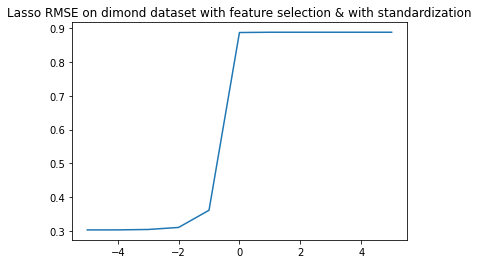

In [ ]:
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Lasso RMSE on dimond dataset with feature selection & with standardization")

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Lasso', alpha_list=alpha_list, feature=diamond_df[['carat','cut', 'color',	'clarity','x', 'y', 'z']], target=diamond_df['price'])

For Lasso Regression, the smallest rmse is 1207.3223 obtained by alpha 1e-05


Text(0.5, 1.0, 'Lasso RMSE on dimond dataset with feature selection & without standardization')

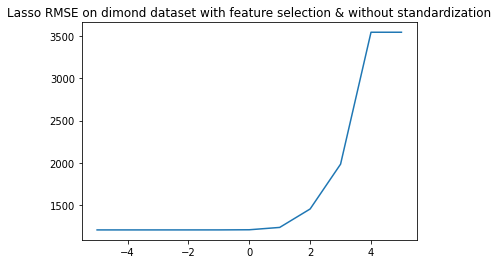

In [ ]:
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Lasso RMSE on dimond dataset with feature selection & without standardization")

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Lasso', alpha_list=alpha_list, feature=diamond_std_df.drop(columns=['price'], inplace=False), target=diamond_std_df['price'])

For Lasso Regression, the smallest rmse is 0.3005 obtained by alpha 1e-05


Text(0.5, 1.0, 'Lasso RMSE on dimond dataset without feature selection & with standardization')

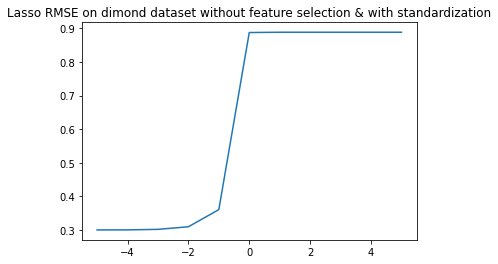

In [ ]:
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Lasso RMSE on dimond dataset without feature selection & with standardization")

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Lasso', alpha_list=alpha_list, feature=diamond_df.drop(columns=['price'], inplace=False), target=diamond_df['price'])

For Lasso Regression, the smallest rmse is 1198.9523 obtained by alpha 1e-05


Text(0.5, 1.0, 'Lasso RMSE on dimond dataset without feature selection & without standardization')

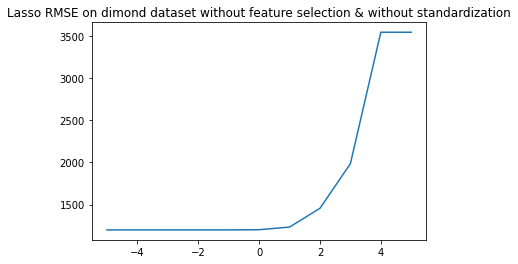

In [ ]:
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Lasso RMSE on dimond dataset without feature selection & without standardization")

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Ridge', alpha_list=alpha_list, feature=diamond_std_df[['carat','cut', 'color',	'clarity','x', 'y', 'z']], target=diamond_std_df['price'])

For Ridge Regression, the smallest rmse is 0.3026 obtained by alpha 1e-05


Text(0.5, 1.0, 'Ridge RMSE on dimond dataset with feature selection & with standardization')

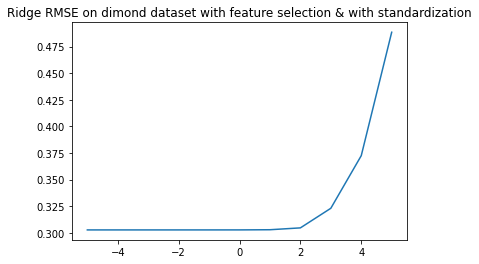

In [ ]:
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Ridge RMSE on dimond dataset with feature selection & with standardization")

For Ridge Regression, the smallest rmse is 1207.3223 obtained by alpha 1e-05


Text(0.5, 1.0, 'Ridge RMSE on dimond dataset with feature selection & without standardization')

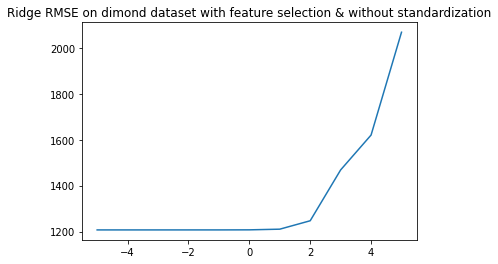

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Ridge', alpha_list=alpha_list, feature=diamond_df[['carat','cut', 'color',	'clarity','x', 'y', 'z']], target=diamond_df['price'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Ridge RMSE on dimond dataset with feature selection & without standardization")

For Ridge Regression, the smallest rmse is 0.3005 obtained by alpha 1e-05


Text(0.5, 1.0, 'Ridge RMSE on dimond dataset without feature selection & with standardization')

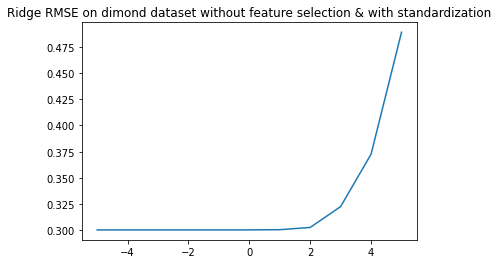

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Ridge', alpha_list=alpha_list, feature=diamond_std_df.drop(columns=['price'], inplace=False), target=diamond_std_df['price'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Ridge RMSE on dimond dataset without feature selection & with standardization")

For Ridge Regression, the smallest rmse is 1198.9523 obtained by alpha 1e-05


Text(0.5, 1.0, 'Ridge RMSE on dimond dataset without feature selection & without standardization')

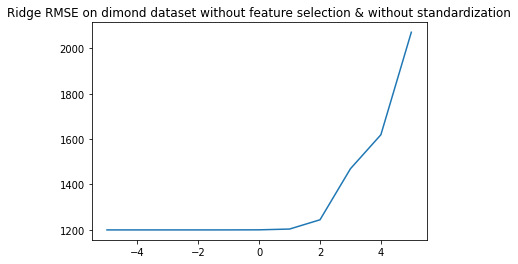

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Ridge', alpha_list=alpha_list, feature=diamond_df.drop(columns=['price'], inplace=False), target=diamond_df['price'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Ridge RMSE on dimond dataset without feature selection & without standardization")

For gas dataset

In [ ]:
linear_regression = LinearRegression(n_jobs=-1)
print("RMSE on dimond dataset with feature selection & with standardization")
print(cross_validation(linear_regression, gt_std_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], gt_std_df['CO']))
print("RMSE on dimond dataset without feature selection & with standardization")
print(cross_validation(linear_regression, gt_std_df.drop(columns=['CO'], inplace=False), gt_std_df['CO']))
print("RMSE on dimond dataset with feature selection & without standardization")
print(cross_validation(linear_regression, gt_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], gt_df['CO']))
print("RMSE on dimond dataset without feature selection & without standardization")
print(cross_validation(linear_regression, gt_df.drop(columns=['CO'], inplace=False), gt_df['CO']))

RMSE on dimond dataset with feature selection & with standardization
(0.6384579791701178, 0.6701609907898923)
RMSE on dimond dataset without feature selection & with standardization
(0.637818867555995, 0.6768361652492954)
RMSE on dimond dataset with feature selection & without standardization
(1.4446010979971424, 1.516333626824299)
RMSE on dimond dataset without feature selection & without standardization
(1.443155017958008, 1.5314371491671634)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.653e+02, tolerance: 3.489e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.463e+03, tolerance: 3.264e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

For Lasso Regression, the smallest rmse is 0.6655 obtained by alpha 0.01


Text(0.5, 1.0, 'Lasso RMSE on dimond dataset with feature selection & with standardization')

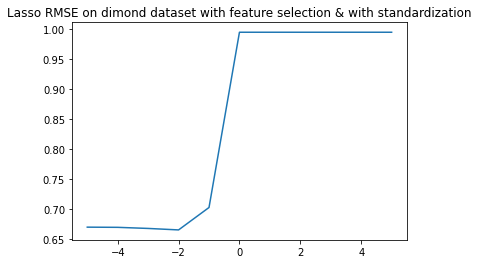

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Lasso', alpha_list=alpha_list, feature=gt_std_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], target=gt_std_df['CO'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Lasso RMSE on dimond dataset with feature selection & with standardization")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e+04, tolerance: 1.786e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+04, tolerance: 1.671e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

For Lasso Regression, the smallest rmse is 1.4912 obtained by alpha 0.1


Text(0.5, 1.0, 'Lasso RMSE on dimond dataset with feature selection & without standardization')

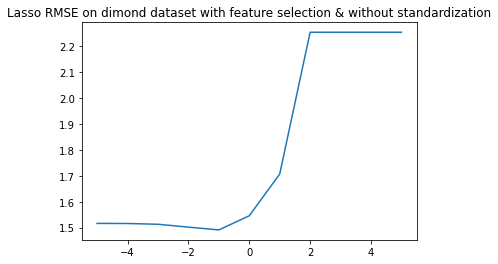

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Lasso', alpha_list=alpha_list, feature=gt_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], target=gt_df['CO'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Lasso RMSE on dimond dataset with feature selection & without standardization")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.470e+03, tolerance: 3.489e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.042e+03, tolerance: 3.264e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

For Lasso Regression, the smallest rmse is 0.6667 obtained by alpha 0.01


Text(0.5, 1.0, 'Lasso RMSE on dimond dataset without feature selection & with standardization')

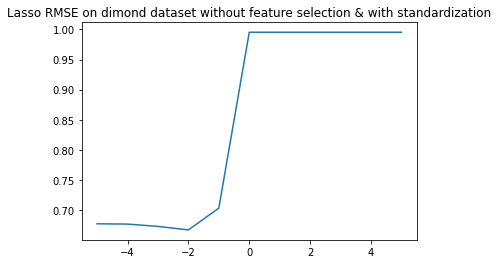

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Lasso', alpha_list=alpha_list, feature=gt_std_df.drop(columns=['CO'], inplace=False), target=gt_std_df['CO'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Lasso RMSE on dimond dataset without feature selection & with standardization")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e+04, tolerance: 1.786e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.307e+04, tolerance: 1.671e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

For Lasso Regression, the smallest rmse is 1.4950 obtained by alpha 0.1


Text(0.5, 1.0, 'Lasso RMSE on dimond dataset without feature selection & without standardization')

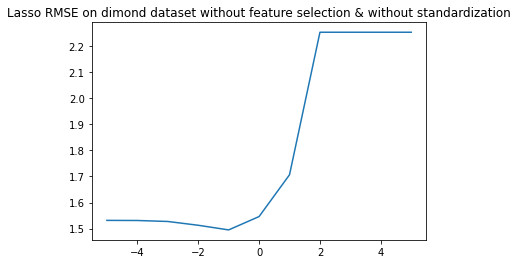

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Lasso', alpha_list=alpha_list, feature=gt_df.drop(columns=['CO'], inplace=False), target=gt_df['CO'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Lasso RMSE on dimond dataset without feature selection & without standardization")

For Ridge Regression, the smallest rmse is 0.6660 obtained by alpha 1000


Text(0.5, 1.0, 'Ridge RMSE on dimond dataset with feature selection & with standardization')

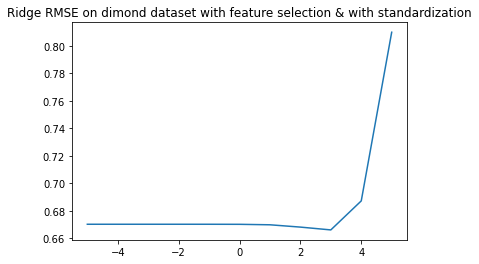

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Ridge', alpha_list=alpha_list, feature=gt_std_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], target=gt_std_df['CO'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Ridge RMSE on dimond dataset with feature selection & with standardization")

For Ridge Regression, the smallest rmse is 1.4914 obtained by alpha 10000


Text(0.5, 1.0, 'Ridge RMSE on dimond dataset with feature selection & without standardization')

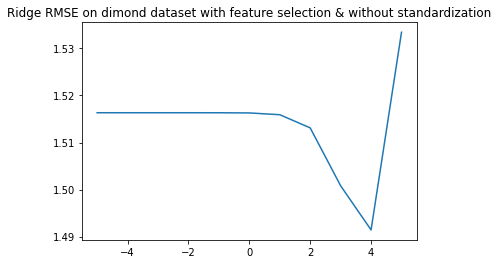

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Ridge', alpha_list=alpha_list, feature=gt_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], target=gt_df['CO'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Ridge RMSE on dimond dataset with feature selection & without standardization")

For Ridge Regression, the smallest rmse is 0.6684 obtained by alpha 1000


Text(0.5, 1.0, 'Ridge RMSE on dimond dataset without feature selection & with standardization')

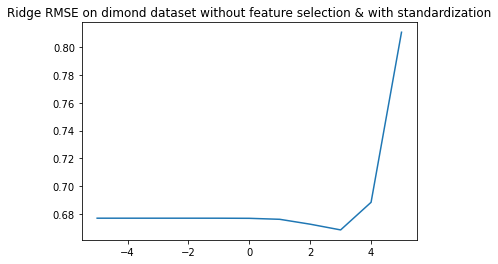

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Ridge', alpha_list=alpha_list, feature=gt_std_df.drop(columns=['CO'], inplace=False), target=gt_std_df['CO'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Ridge RMSE on dimond dataset without feature selection & with standardization")

For Ridge Regression, the smallest rmse is 1.4964 obtained by alpha 10000


Text(0.5, 1.0, 'Ridge RMSE on dimond dataset without feature selection & without standardization')

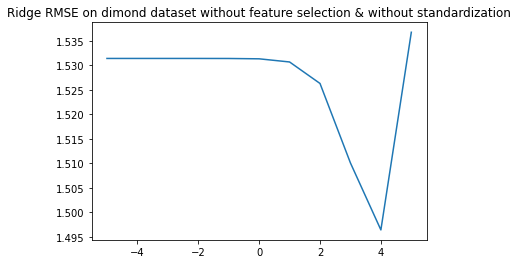

In [ ]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Ridge', alpha_list=alpha_list, feature=gt_df.drop(columns=['CO'], inplace=False), target=gt_df['CO'])
plt.plot(range(-5, 6), test_rmse_list)
plt.title("Ridge RMSE on dimond dataset without feature selection & without standardization")

**For dimond dataset:** Lasso regression with standardization and without feature selection has the lowest RMSE around 0.3005 with alpha equal to 1e-05


  **For gas dataset:**
  Lasso regression with both standardization and feature selection has the lowest RMSE around 0.6655 with alpha equal to 0.01


### Question 10: Does feature scaling play any role (in the cases with and without regularization)?

Prevent overfitting. if we scale the features and apply regularization it will give better result than no scaling with regularization. The reason is these models get affected by outliers. Check our report from Q9 where we tested the test RMSE with regards to feature scaling.

### Question 11: What is the meaning of p-values and how can you infer the most significant features?

The p-value for each term tests the null hypothesis that the coefficient is equal to zero. A low p-value indicates we can reject the null-hypothesis, i.e., a low p value means that this feature is significant while a large p value indicates the feature is possibly irrelavent.

### Question 12: Look up for the most salient features and interpret them. 

In [ ]:
poly = PolynomialFeatures()
diamond_X = diamond_df.drop(columns=['price'], inplace=False)
diamond_X
diamond_Y = diamond_df['price']
diamond_poly = poly.fit_transform(diamond_X)
features = poly.get_feature_names_out(diamond_X.columns)

diamond_mi = mutual_info_regression(diamond_poly, diamond_Y)
res = []

for i in range(len(diamond_mi)):
  res.append((features[i], diamond_mi[i]))

res.sort(key=lambda x:x[1], reverse=True)

for f in res:
  print(f[0], f[1])

# features

carat^2 1.6553332569061765
carat 1.652469448712715
carat y 1.5702983612043333
carat x 1.5557404857223691
carat clarity 1.5135920200620383
carat table 1.5130372190361996
carat z 1.5100255240428302
y 1.4229830583059364
y^2 1.4219155068698832
y z 1.4212629028448305
x z 1.4189398828065638
x 1.4126511780505302
x^2 1.4112254874497845
carat depth 1.4028656195778613
x y 1.3996629916825212
carat color 1.398277370274612
z^2 1.3608761729955958
z 1.3603004233330376
depth y 1.3177979581019228
depth x 1.3146178831094906
carat cut 1.2885068905307158
clarity x 1.2687448331378421
clarity y 1.2562589720113362
clarity z 1.2176625880345222
table z 1.1654087673787457
depth z 1.1308458412798705
table x 1.1231962546998195
table y 1.1152004944707992
cut z 1.0572087935454881
cut x 1.0553665580679379
cut y 1.0462103685025017
color y 1.0034806101065117
color x 0.997917889975457
color z 0.9885130158311828
color clarity 0.44267694136238367
clarity table 0.23982162947597097
cut clarity 0.23215571648716393
clarity^2

In [ ]:
poly = PolynomialFeatures()
gt_X = gt_df.drop(columns=['CO'], inplace=False)
gt_X
gt_Y = gt_df['CO']
gt_poly = poly.fit_transform(gt_X)
features = poly.get_feature_names_out(gt_X.columns)

gt_mi = mutual_info_regression(gt_poly, gt_Y)
res = []

for i in range(len(gt_mi)):
  res.append((features[i], gt_mi[i]))

res.sort(key=lambda x:x[1], reverse=True)

for f in res:
  print(f[0], f[1])

TIT Year 0.5740953389149244
TIT^2 0.5375523280681902
TIT 0.5375515413044143
TAT TEY 0.5266173063092232
TIT TEY 0.5178843890104536
TAT CDP 0.4986981071164198
TEY CDP 0.49831715031044954
TIT CDP 0.4981310294009713
TEY Year 0.49811434305026303
TEY^2 0.49567657720005176
TEY 0.4954731224569029
GTEP TEY 0.48611959830628493
CDP^2 0.47428075411279647
CDP 0.47417108033968525
CDP Year 0.47037436121707543
GTEP TIT 0.46758595048704255
AP TEY 0.4656910492021922
GTEP CDP 0.4622618059718464
GTEP TAT 0.456956650581966
GTEP^2 0.44603918037417944
GTEP 0.4454612323592002
GTEP Year 0.4421523640813829
AP GTEP 0.4408666644605459
AP CDP 0.43322327856843224
AFDP TEY 0.39848013938411775
TIT TAT 0.39788605212057515
AP TIT 0.3968008303025945
AFDP GTEP 0.3858933567825815
AFDP CDP 0.36634893428229454
AFDP TIT 0.30531197109807984
AP AFDP 0.28763956186910544
AFDP TAT 0.28581011047341587
AFDP Year 0.28153977996885704
AFDP^2 0.27873439041069403
AFDP 0.2786037098905014
TAT Year 0.2044652065299406
TAT^2 0.16159515236362




*   For the diamond dataset, the salient features are carat with different combinations of maybe x, y, z, clarity. This corresponds to our heatmap back in Q2 where carat has highest correlation with target price. The larger the carat, the more expensive the price.
*   For the gas dataset, the salient features are TIT with different combinations. This also corresponds to our heatmap in Q2 in which the greater the TIT is, the smaller the CO emission.




### Question 13: What degree of polynomial is best? What does a very high-order polynomial imply about the fit on the training data? How do you choose this parameter?

In [ ]:
degree = list(range(3, 9))
best_rmse, best_d_diamond = float('inf'), 0
diamond_rmse_list = []
for d in tqdm(degree):
    polyreg = make_pipeline(PolynomialFeatures(d), LinearRegression())
    train_rmse, test_rmse = cross_validation(polyreg, diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']], diamond_std_df['price'])
    diamond_rmse_list.append(test_rmse)
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_d_diamond = d
print("For Polynomial Regression, the smallest rmse is {:.4f} obtained by degree {}".format(best_rmse, best_d_diamond))

100%|██████████| 6/6 [35:49<00:00, 358.25s/it]

For Polynomial Regression, the smallest rmse is 13.4161 obtained by degree 3


Text(0.5, 1.0, 'Diamond dataset RMSE for polynomial regression ')

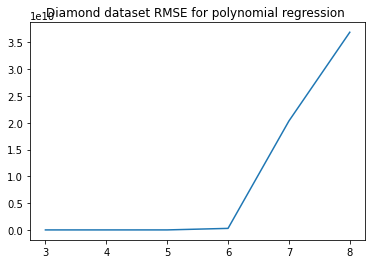

In [ ]:
plt.plot(range(3, 9), diamond_rmse_list)
plt.title("Diamond dataset RMSE for polynomial regression ")
# diamond_rmse_list

In [13]:
degree = list(range(3, 9))
best_rmse, best_d_gt = float('inf'), 0
gt_rmse_list = []
for d in tqdm(degree):
    polyreg = make_pipeline(PolynomialFeatures(d), LinearRegression())
    train_rmse, test_rmse = cross_validation(polyreg, gt_std_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], gt_std_df['CO'])
    gt_rmse_list.append(test_rmse)
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_d_gt = d
print("For Polynomial Regression, the smallest rmse is {:.4f} obtained by degree {}".format(best_rmse, best_d_gt))

100%|██████████| 6/6 [2:56:38<00:00, 1766.33s/it]

For Polynomial Regression, the smallest rmse is 0.6455 obtained by degree 3


Text(0.5, 1.0, 'Gas dataset RMSE for polynomial regression ')

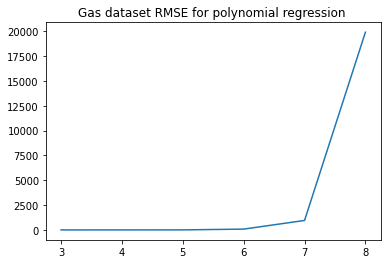

In [14]:
plt.plot(range(3, 9), gt_rmse_list)
plt.title("Gas dataset RMSE for polynomial regression ")

High-order polynomial implies that the model is probably overfitting. To choose the degree parameter, we need to focus on the test rmse to actually see the generalization power of the model. We iterate the degree parameter from 3 to 9 to choose the best one with lowest rmse. And we do observe that from both datasets that degree 3 has the lowest test RMSE.

### Question 14: Craft new feature and check if it boosts accuracy

In [ ]:
new_feature = [diamond_std_df['x'][i] * diamond_std_df['y'][i] * diamond_std_df['z'][i] for i in range(diamond_std_df.shape[0])]
new_feature = StandardScaler().fit_transform(np.array(new_feature).reshape(-1, 1))
diamond_std_df['new_feature'] = new_feature

In [ ]:
polyreg = make_pipeline(PolynomialFeatures(best_d_diamond), LinearRegression())
train_rmse, test_rmse = cross_validation(polyreg, diamond_std_df[['carat', 'cut', 'color','clarity', 'new_feature']], diamond_std_df['price'])

In [ ]:
test_rmse

0.5239636346915312

Yes crafting the new feature boosts the accuracy for our diamond dataset(having significantly smaller test RMSE as compared from the above questions.) The new feature has all the related factors which we observed from feature selections, and the accuracy is directly proportional to these factors. 

### Question 15: Why does neural network do much better than linear regression?

Neural network is able to deal with non-linearities while linear regression depends on certain linear dependency between features and target. If there is indeed non-linearities in the dataset, then neural network is expected to be better than linear regression.

### Question 16: Adjust your network size and weight decay as regularization. Find a good hyper-parameter set systematically

In [ ]:
lr_list = [0.001, 0.01, 0.1]
first_layer = [128, 256, 512]
second_layer = [128, 256, 512]
third_layer = [128, 256, 512]
best_setting = None
best_rmse = float('inf')
for lr in tqdm(lr_list):
    for fl in first_layer:
        for sl in second_layer:
            for tl in third_layer:
                mlp = MLPRegressor(learning_rate_init=lr, hidden_layer_sizes=(fl, sl, tl), learning_rate="invscaling", max_iter=300)
                train_rmse, test_rmse = cross_validation(mlp, diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']], diamond_std_df['price'], n_splits=3)
                if test_rmse < best_rmse:
                    best_rmse = test_rmse
                    best_setting = (lr, fl, sl, tl)
print('The test RMSE is', best_rmse)
print(best_setting)

100%|██████████| 3/3 [2:23:25<00:00, 2868.46s/it]

The test RMSE is 0.36195600674196365
(0.01, 256, 128, 128)


In [ ]:
lr_list = [0.001, 0.01, 0.1]
first_layer = [128, 256, 512]
second_layer = [128, 256, 512]
third_layer = [128, 256, 512]
best_setting = None
best_rmse = float('inf')
for lr in tqdm(lr_list):
    for fl in first_layer:
        for sl in second_layer:
            for tl in third_layer:
                mlp = MLPRegressor(learning_rate_init=lr, hidden_layer_sizes=(fl, sl, tl), learning_rate="invscaling", max_iter=300)
                train_rmse, test_rmse = cross_validation(mlp, gt_std_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], gt_std_df['CO'], n_splits=3)
                if test_rmse < best_rmse:
                    best_rmse = test_rmse
                    best_setting = (lr, fl, sl, tl)
print('The test RMSE is', best_rmse)
print(best_setting)

100%|██████████| 3/3 [4:22:52<00:00, 5257.55s/it]

The test RMSE is 0.7147417701409534
(0.001, 512, 128, 512)


We ran experiments on different sets of hyper parameters for the neural networks. For the diamond dataset, a good hyper-parameter set is lr = 0.01, fl=512, sl=128, tl=512 with the test RMSE equaling to 0.3619. For the gas data set, a good hyper-parameter set is lr=0.001, fl=512, sl=128, tl=512

### Question 17: What activation function should be used for the output?

We can use relu activation function to keep the continuity and linearility of the output while adding non-linearility to the model to grant it more generalization power.

### Question 18: What is the risk of increasing the depth of the network too far?

It will overfit the data and thus reults in poor validation performance while slowing down the training process.

### Question 19. Fine-tune your model. Explain how these hyper-parameters affect the overall performance? Do some of them have regularization effect?

In [57]:
feature_list = list(range(1, 7))
tree_list = list(range(10, 100, 10))
depth = list(range(1, 5))
best_setting = None
best_rmse = float('inf')
for f in feature_list:
    for num_tree in tree_list:
        for d in depth:
            rf = RandomForestRegressor(n_estimators=num_tree, max_depth=d, max_features=f)
            train_rmse, test_rmse = cross_validation(rf, diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']], diamond_std_df['price'], n_splits=3)
            if test_rmse < best_rmse:
                best_rmse = test_rmse
                best_setting = (f, num_tree, d)
print(best_rmse)
print(best_setting)

0.6693953813898532
(2, 40, 4)


In [ ]:
depth = list(range(1, 8))
best_setting = None
best_rmse = float('inf')
for f in feature_list:
    for num_tree in tree_list:
        for d in depth:
            rf = RandomForestRegressor(n_estimators=num_tree, max_depth=d, max_features=f)
            train_rmse, test_rmse = cross_validation(rf, gt_std_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], gt_std_df['CO'], n_splits=3)
            if test_rmse < best_rmse:
                best_rmse = test_rmse
                best_setting = (f, num_tree, d)
print(best_rmse)
print(best_setting)

(2, 60, 5)


1. Max features: increasing this parameter generally boost the model performance, but it also decreases the diversity of each tree which is what makes random forest powerful. Also, too many features will obviously slow down the training process.
2. Number of trees: this parameter also increases model performance and enables the predictions to be more stable and realiable. This merit also comes at the cost of training speed. 
3. Depth of trees: too deep a tree will eventually overfit the data and too shallow a tree will not have enough generalization power. Normally we need a sub tree that is just deep enough but not enough to overfit and slow down the training process.

### Question 20: Why does random forest perform well?


Random forest is a kind of ensemble algorithm which gathers multiple individually-powerless classifier/regressor into a mutual prediction. These sub trees are relatively uncorrelated as a result of randomly chosen features and structures. In this way it reduces overfitting problem in decision trees and also reduces the variance and therefore improves the accuracy. Ensemble algorithms can be proven to improve performance of individual classifier/regressor by many literatures.

### Question 21: Which feature is selected for branching at the root node? What can you infer about the importance of features? Do the important features match what you got in part 3.2.1?

In [67]:
# (2, 40, 4)
diamond_rf = RandomForestRegressor(n_estimators=40, max_depth=4, max_features=2)
diamond_rf.fit(diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']], diamond_std_df['price'])
diamond_subtree = diamond_rf.estimators_[0]
print(diamond_subtree)

DecisionTreeRegressor(max_depth=4, max_features=2, random_state=260383534)


In [70]:
# (2, 60, 5)
gt_rf = RandomForestRegressor(n_estimators=60, max_depth=5, max_features=2)
gt_rf.fit(gt_std_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']], gt_std_df['CO'])
gt_subtree = gt_rf.estimators_[0]
print(gt_subtree)

DecisionTreeRegressor(max_depth=5, max_features=2, random_state=1434166640)


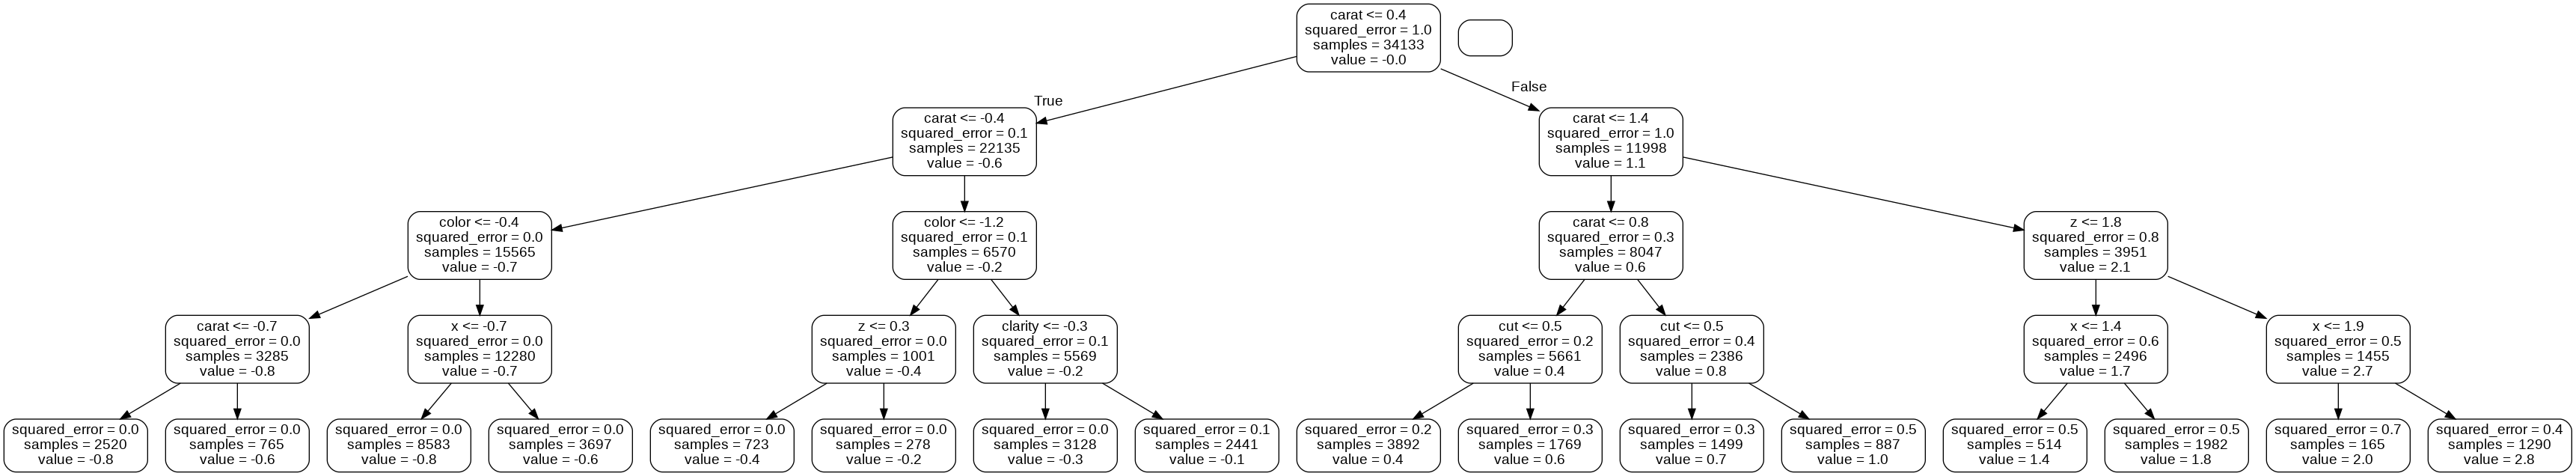

In [72]:
# from sklearn.tree import plot_tree

# fig = plt.figure(figsize=(20, 20))
# plot_tree(subtree, 
#           filled=True, impurity=True, 
#           rounded=True)

export_graphviz(diamond_subtree, out_file = 'tree.dot', feature_names = diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']].columns, precision = 1, rounded= True)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
Image(graph.create_png())

The root feature is 'carat' <= 0.4. These features which are selected as branching node are important to decide the final value interval of the regressor, which means that they are highly correlated to the target price. These important features in some extent match what we got in previous part, where we got carat, cut, color,clarity, x, y and z but here we have carat, color, cut,clarity, x, and z

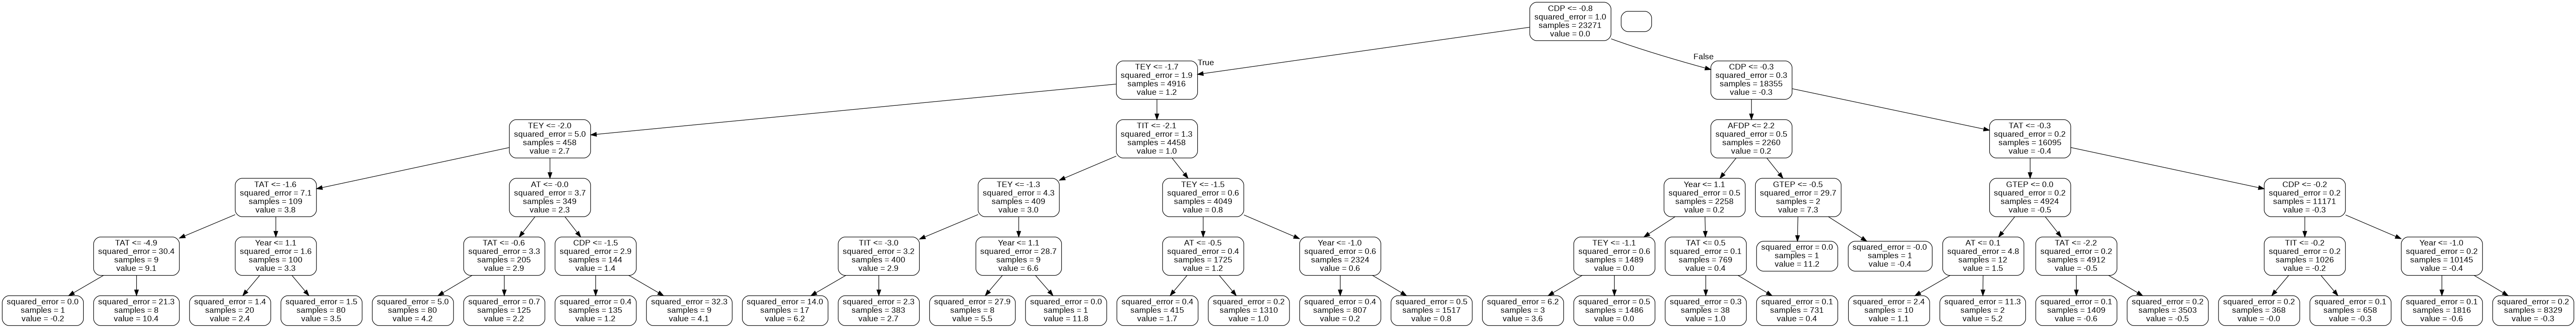

In [73]:
export_graphviz(gt_subtree, out_file = 'tree1.dot', feature_names = gt_std_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']].columns, precision = 1, rounded= True)
(graph, ) = pydot.graph_from_dot_file('tree1.dot')
Image(graph.create_png())

The root feature is 'CDP' <= -0.8. These important features in some extent match what we got in previous part, where we got 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year', and here we have CDP, AFDP, YEAR, TEY, TAT, GTEP, TIT, and AT

### Question 22: experiment on the picked dataset to determine the important hyperparameters along with a proper search space for the tuning of these parameters.

In [ ]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2', 'l1'},
#     'num_leaves': 10,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0,
#     'force_col_wise':True
# }
# n_splits = 10
# kf = KFold(n_splits=n_splits)
# train_rmse, test_rmse = 0, 0
# X = diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']]
# y = diamond_std_df['price']
# for train, test in kf.split(X):
#     train_data, train_target = X.loc[train], y.loc[train]
#     test_data, test_target = X.loc[test], y.loc[test]
#     lgb_train = lgb.Dataset(train_data, train_target)
#     lgb_test = lgb.Dataset(test_data, test_target)
#     model = lgb.train(params, lgb_train)
#     train_pred, test_pred = model.predict(train_data), model.predict(test_data)
#     train_rmse += metrics.mean_squared_error(train_target, train_pred) ** 0.5
#     test_rmse += metrics.mean_squared_error(test_target, test_pred) ** 0.5
# print(train_rmse/n_splits, test_rmse/n_splits)

0.15267846794108336 0.19337989229813485


In [16]:
X = diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']]
y = diamond_std_df['price']

num_leaves = [10, 50, 100, 200, 500]
n_estimator = [10, 30, 50, 70, 90, 110, 130]
max_depth = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

kf = KFold(n_splits=10)
best_rmse = float('inf')

for l in num_leaves:
  for n in n_estimator:
    for d in max_depth:
      clf = lgb.LGBMRegressor(num_leaves=l, n_estimator = n, max_depth = d)
      train_rmse,test_rmse = cross_validation(clf, X, y)
    
      if test_rmse < best_rmse:
          best_rmse = test_rmse
          best_setting = (l,n,d)

In [17]:
best_rmse

0.1661640513400095

In [18]:
best_setting

(50, 10, 9)

In [16]:
X = diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']]
y = diamond_std_df['price']

colsample_bylevel = [0.1, 0.3, 0.5]
l2_leaf_reg = [10.0**x for x in np.arange(-2,2)]
max_depth = [1, 3, 5, 7, 9]

kf = KFold(n_splits=10)
best_rmse = float('inf')

for c in colsample_bylevel:
  for l in l2_leaf_reg:
    for d in max_depth:
      print(c,l,d)
      clf = CatBoostRegressor(verbose=False,colsample_bylevel=c, l2_leaf_reg = l, max_depth = d)
      train_rmse,test_rmse = cross_validation(clf, X, y)
    
      if test_rmse < best_rmse:
          best_rmse = test_rmse
          best_setting = (c,l,d)

0.1 0.01 1


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0.1 0.01 3
0.1 0.01 5
0.1 0.01 7
0.1 0.01 9
0.1 0.1 1
0.1 0.1 3
0.1 0.1 5
0.1 0.1 7
0.1 0.1 9
0.1 1.0 1
0.1 1.0 3
0.1 1.0 5
0.1 1.0 7
0.1 1.0 9
0.1 10.0 1
0.1 10.0 3
0.1 10.0 5
0.1 10.0 7
0.1 10.0 9
0.3 0.01 1
0.3 0.01 3
0.3 0.01 5
0.3 0.01 7
0.3 0.01 9
0.3 0.1 1
0.3 0.1 3
0.3 0.1 5
0.3 0.1 7
0.3 0.1 9
0.3 1.0 1
0.3 1.0 3
0.3 1.0 5
0.3 1.0 7
0.3 1.0 9
0.3 10.0 1
0.3 10.0 3
0.3 10.0 5
0.3 10.0 7
0.3 10.0 9
0.5 0.01 1
0.5 0.01 3
0.5 0.01 5
0.5 0.01 7
0.5 0.01 9
0.5 0.1 1
0.5 0.1 3
0.5 0.1 5
0.5 0.1 7
0.5 0.1 9
0.5 1.0 1
0.5 1.0 3
0.5 1.0 5
0.5 1.0 7
0.5 1.0 9
0.5 10.0 1
0.5 10.0 3
0.5 10.0 5
0.5 10.0 7
0.5 10.0 9


In [17]:
best_rmse

0.14119106782530566

In [18]:
best_setting

(0.5, 0.01, 5)

we experimented some hyperparameters and obtained some good values of these parameters with reasonable test RMSE. We tried Baysearchcv in 23 as well to experiment on the hyperparameters.

### Question 23

In [35]:
X = diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']]
y = diamond_std_df['price']

optimum_lgbm = BayesSearchCV(
    lgb.LGBMRegressor(),
    {
        'num_leaves': np.arange(10, 1000, 10),
        'max_depth': np.arange(1,20,2),
        'learning_rate':(0.1, 0.5),
    },
    n_iter = 20,
    cv = 10,
    n_jobs = -1,
    verbose = 1,
    scoring = 'neg_root_mean_squared_error',
    return_train_score = True
)

In [36]:
optimum_lgbm.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


BayesSearchCV(cv=10, estimator=LGBMRegressor(), n_iter=20, n_jobs=-1,
              return_train_score=True, scoring='neg_root_mean_squared_error',
              search_spaces={'learning_rate': (0.1, 0.5),
                             'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                             'num_leaves': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520,
       530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780,
       790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910,
       920, 930, 940, 950, 960, 970, 980, 990])},
              verbose=1)

In [38]:
X = diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']]
y = diamond_std_df['price']
optimum_catboost = BayesSearchCV(
    CatBoostRegressor(),
    {
        'colsample_bylevel': np.arange(0.1, 1.0,0.1),
        'max_depth': np.arange(1,16,2),
        'num_trees': np.arange(10, 500, 100),
        'l2_leaf_reg': [10.0**x for x in np.arange(-3, 3)]
    },
    n_iter = 20,
    cv = 10,
    n_jobs = -1,
    verbose = 1,
    scoring = 'neg_root_mean_squared_error',
    return_train_score = True
)

In [39]:
optimum_catboost.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

BayesSearchCV(cv=10,
              estimator=<catboost.core.CatBoostRegressor object at 0x7faeef1ee490>,
              n_iter=20, n_jobs=-1, return_train_score=True,
              scoring='neg_root_mean_squared_error',
              search_spaces={'colsample_bylevel': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                             'l2_leaf_reg': [0.001, 0.01, 0.1, 1.0, 10.0,
                                             100.0],
                             'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15]),
                             'num_trees': array([ 10, 110, 210, 310, 410])},
              verbose=1)

In [40]:
optimum_lgbm.best_score_

-0.15666624709964377

In [41]:
optimum_lgbm.best_params_

OrderedDict([('learning_rate', 0.5), ('max_depth', 3), ('num_leaves', 10)])

In [42]:
optimum_catboost.best_score_

-0.1490208127863788

In [43]:
optimum_catboost.best_params_

OrderedDict([('colsample_bylevel', 0.6),
             ('l2_leaf_reg', 1.0),
             ('max_depth', 11),
             ('num_trees', 410)])

Since we are using the 'neg_root_mean_squared_error' for the scoring parameter of the Baysearchcv, the best RMSE for LGBMRegressor is around -0.16, and the best RMSE for CatboostRegressor is -0.15. The best parameters found for LGBM are ('learning_rate', 0.5), ('max_depth', 3), ('num_leaves', 10) And the best parameters found for Catboost are ('colsample_bylevel', 0.6),('l2_leaf_reg', 1.0),('max_depth', 11),('num_trees', 410)

### Question 24

In [44]:
lgbm_param_list = ['param_learning_rate', 'param_max_depth', 'param_num_leaves']
catboost_param_list = ['param_colsample_bylevel','param_l2_leaf_reg','param_max_depth']

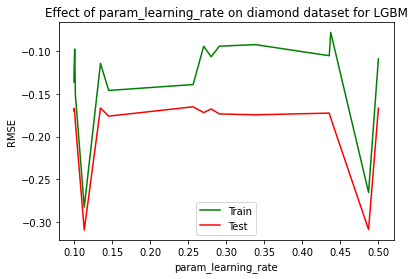

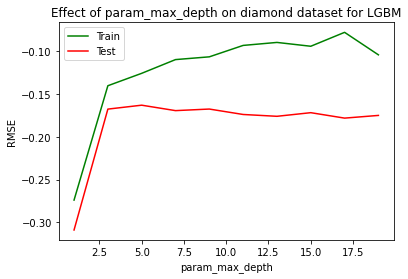

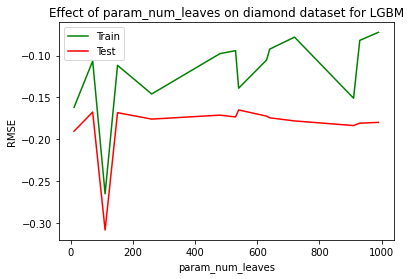

In [45]:
for p in lgbm_param_list:
  params = sorted(list(set(optimum_lgbm.cv_results_[p])))
  train = []
  test = []

  for item in params:
    train_score = [optimum_lgbm.cv_results_['mean_train_score'][k] for k in [i for i, j in enumerate(optimum_lgbm.cv_results_[p]) if j == item]]
    train.append(np.mean(train_score))
    test_score = [optimum_lgbm.cv_results_['mean_test_score'][k] for k in [i for i, j in enumerate(optimum_lgbm.cv_results_[p]) if j == item]]
    test.append(np.mean(test_score))
  plt.figure()
  plt.title('Effect of ' + str(p) + ' on diamond dataset for LGBM')
  plt.plot(params, train, label="Train", color='g')
  plt.plot(params, test, label="Test", color='r')
  plt.xlabel(str(p))
  plt.ylabel('RMSE')
  plt.legend()
  plt.show()

We can observe that increasing the parameter max_depth improves RMSE for both the train and test set. This might be due to the fact that increasing the depth of a tree improves fitting and generalization

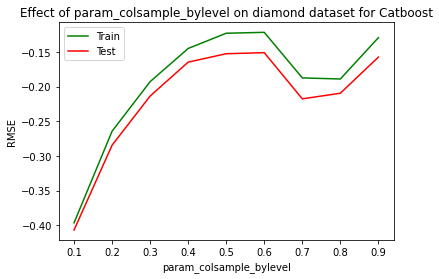

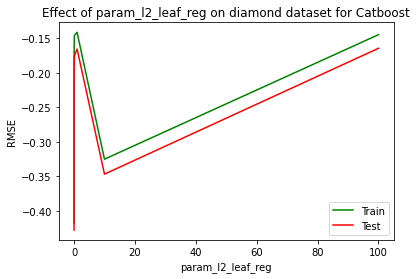

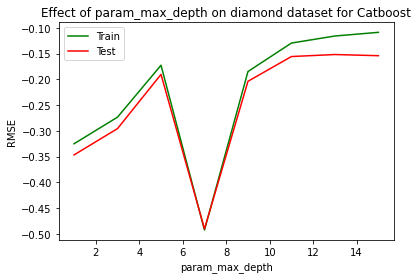

In [46]:
for p in catboost_param_list:
  params = sorted(list(set(optimum_catboost.cv_results_[p])))
  train = []
  test = []

  for item in params:
    train_score = [optimum_catboost.cv_results_['mean_train_score'][k] for k in [i for i, j in enumerate(optimum_catboost.cv_results_[p]) if j == item]]
    train.append(np.mean(train_score))
    test_score = [optimum_catboost.cv_results_['mean_test_score'][k] for k in [i for i, j in enumerate(optimum_catboost.cv_results_[p]) if j == item]]
    test.append(np.mean(test_score))
  plt.figure()
  plt.title('Effect of ' + str(p) + ' on diamond dataset for Catboost')
  plt.plot(params, train, label="Train", color='g')
  plt.plot(params, test, label="Test", color='r')
  plt.xlabel(str(p))
  plt.ylabel('RMSE')
  plt.legend()
  plt.show()

We do observe that for Catboost, col_sample_bylevel kind of improves the RMSE while at certain points decreases the test RMSE. This parameter selects a certain fraction of the features to use at each split. When values of this is too small it will hurt model performance. This also acts as a regularizer for the model because it only selects the most salient features that have an impact on most samples per fraction.

### Question 25

In [93]:
X = diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']]
y = diamond_std_df['price']

##### For LGMBRegressor

In [77]:
lgbm = lgb.LGBMRegressor(learning_rate= 0.5, max_depth= 3, num_leaves=10)
train_rmse,test_rmse = cross_validation(lgbm, X, y)
print(train_rmse)
print(test_rmse)

0.1327772337247906
0.15666624709964377


##### For CatboostRegressor

In [82]:
cat = CatBoostRegressor(verbose=False,colsample_bylevel=0.6 ,l2_leaf_reg=1.0, max_depth=11, num_trees=410)
train_rmse,test_rmse = cross_validation(cat, X, y)
print(" ")
print(train_rmse)
print(test_rmse)

 
0.11759136940540094
0.1490208127863788


##### For RandomForestRegressor

In [85]:
random_forest = diamond_rf
train_rmse,test_rmse = cross_validation(random_forest, X, y)
print(train_rmse)
print(test_rmse)

0.27893608092143074
0.32717178978788897


##### For MLPRegressor

In [84]:
mlp = MLPRegressor(learning_rate_init=0.01, hidden_layer_sizes=(256, 128, 128), learning_rate="invscaling", max_iter=300)
train_rmse,test_rmse = cross_validation(mlp, X, y)
print(train_rmse)
print(test_rmse)

0.14562620051348651
0.19308066997335288


For PolynomialFeatures

In [86]:
polyreg = make_pipeline(PolynomialFeatures(3), LinearRegression())
train_rmse,test_rmse = cross_validation(polyreg, X, y)
print(train_rmse)
print(test_rmse)

0.15187259440090434
13.416057432170172


For Lasso Regression

In [89]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Lasso', alpha_list=alpha_list, feature=X, target=y)
print(min(train_rmse_list))
print(min(test_rmse_list))

For Lasso Regression, the smallest rmse is 0.3026 obtained by alpha 1e-05
0.300991831674045
0.30264178431232636


##### For Ridge Regression

In [92]:
train_rmse_list, test_rmse_list = test_reg_scheme(model='Ridge', alpha_list=alpha_list, feature=X, target=y)
print(min(train_rmse_list))
print(min(test_rmse_list))

For Ridge Regression, the smallest rmse is 0.3026 obtained by alpha 1e-05
0.30099179935896436
0.3026321417111066


The training RMSE is different from that of validation test RMSE for every model. And we do observe that the train RMSE is smaller than test RMSE in every case as well. One reason might be the overfitting issue. Our model will be trained on the train data and get lower RMSE while at certain point, it will overfit the test data, which results in higher test RMSE as compared to the train RMSE.

### Question 26

In [54]:
# 2, 40, 4 for diamond random forest | (2, 60, 5) for gas random forest

diamond_X = diamond_std_df[['carat','cut', 'color','clarity','x', 'y', 'z']]
diamond_y = diamond_std_df['price']

gt_X = gt_std_df[[ 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'Year']]
gt_y = gt_std_df['CO']

drf_clf = RandomForestRegressor(n_estimators=40, max_depth=4, max_features=2, oob_score=True).fit(diamond_X, diamond_y)
grf_clf = RandomForestRegressor(n_estimators=60, max_depth=5, max_features=2, oob_score=True).fit(gt_X, gt_y)

diamond_r2, diamond_oob = drf_clf.score(diamond_X, diamond_y), drf_clf.oob_score_
gt_r2, gt_oob = grf_clf.score(gt_X, gt_y), grf_clf.oob_score_

print('diamond dataset, OOB score is: ', diamond_oob, 
      'diamond dataset, r2 score is: ', diamond_r2)
print('gas dataset, OOB score is: ', gt_oob,
      'gas dataset, r2 score is: ', gt_r2)

diamond dataset, OOB score is:  0.9174139121347654 diamond dataset, r2 score is:  0.9197487338537744
gas dataset, OOB score is:  0.6999165119878138 gas dataset, r2 score is:  0.7309284879872957


OOB error in random forest regression is computed on the samples that are not seen during training. When training random forest model, we will not use the entire sample, and those unused samples can be used to find the prediction error. While R2 score provides a measurement of how well the model fits the samples, it indicates if the observed variation could be explained by the random forest model.

In [ ]:
with open("tweets_#gohawks.txt", "r") as f:
    for line in f:
        tweet = json.loads(line)
        json_formatted_str = json.dumps(tweet, indent=2)
        #print(json_formatted_str)
        #print(tweet.keys())
        #print(tweet['tweet'].keys())
        break